In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [54]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [55]:
#load the dataset
full_dataset=pd.read_csv('full_dataset(Revised).csv')

test_dataset=pd.read_csv('full_test_data(Revised).csv')

In [58]:
#process the df[date]'s format to date time
full_dataset['date'] = pd.to_datetime(full_dataset['date'])
test_dataset['date'] = pd.to_datetime(test_dataset['date'])

#filter the 2016 dataset for training and taking out the 2016 from the test_dataset
train_df = full_dataset[full_dataset['date'].dt.year.isin([2016, 2017, 2018, 2019])]
test_df = test_dataset[test_dataset['date'].dt.year == 2020]

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [60]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             5029 non-null   object        
 1   date              5029 non-null   datetime64[ns]
 2   content_original  5029 non-null   object        
 3   bias              5029 non-null   int64         
 4   bias_text         5029 non-null   object        
 5   source            5029 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 235.9+ KB


In [61]:
train_df.head(1)

title       date  \
0  trump’s tariff barrage push china fight point return 2018-07-11   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [62]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (12222, 6)


In [63]:
test_df.head(1)

title       date  \
4  the human cost trump guest worker ban 2020-06-29   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [64]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (562, 6)


In [65]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

test_text = test_df['content_original']
test_text_labels = test_df['bias']


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  12222

size of testing dataset:  562

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [66]:
MAX_SEQUENCE_LENGTH = 512

In [67]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

# #tokenizing the validate text
# x_validate = bert_tokenizer(validate_text.tolist(),
#               max_length=MAX_SEQUENCE_LENGTH,
#               truncation=True,
#               padding='max_length',
#               return_tensors='tf')
# y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [68]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning with One LSTM Layer

In [69]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.1,
                                     attention_probs_dropout_prob = 0.1,
                                     hidden_dropout_prob=0.1,
                                    #  lstm_units=90,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [70]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [71]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

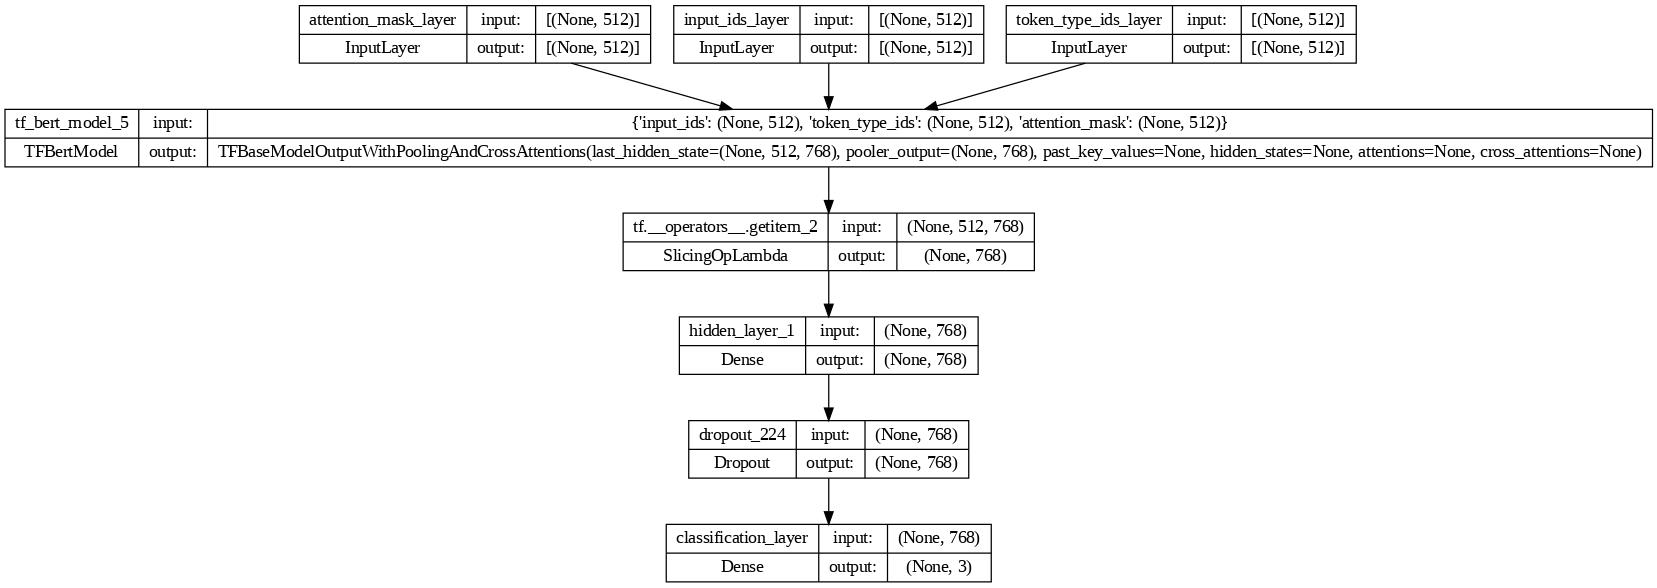

In [72]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=16,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


764/764 [==============================] - 371s 435ms/step - loss: 0.8483 - accuracy: 0.5824 - val_loss: 0.7504 - val_accuracy: 0.6762
Epoch 2/4
143/764 [====>.........................] - ETA: 4:22 - loss: 0.4756 - accuracy: 0.8125

In [ ]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

In [ ]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

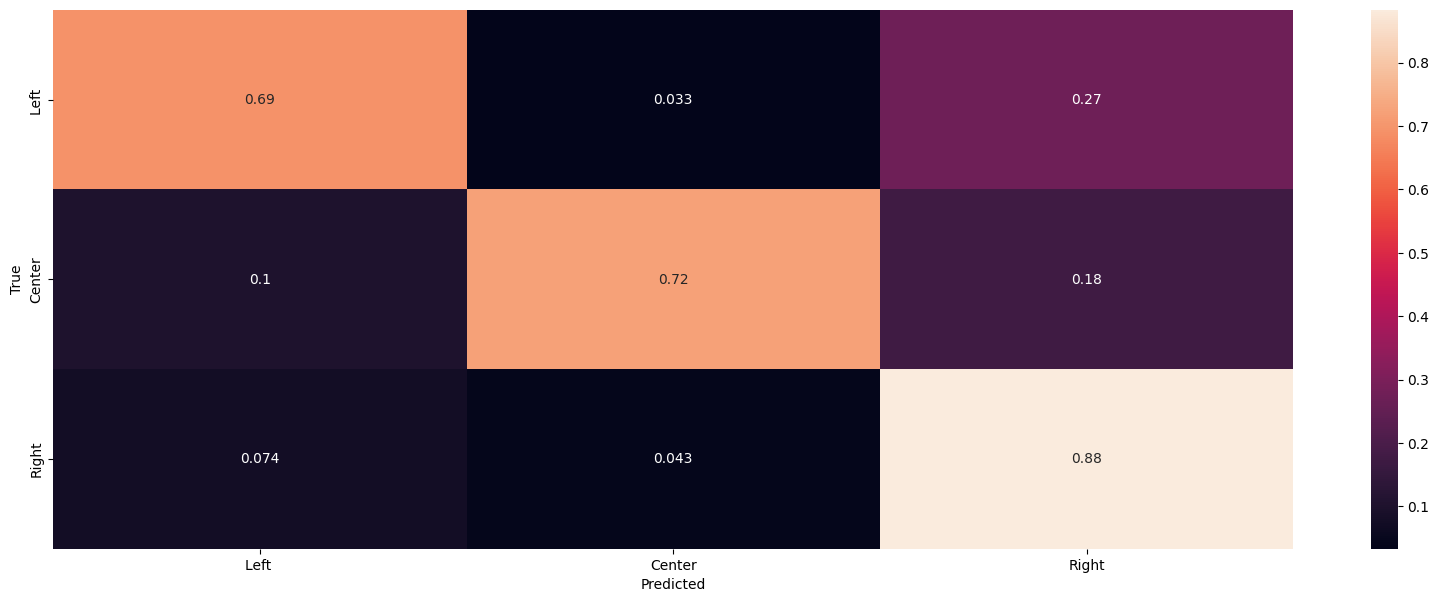

In [79]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [80]:
bert_cls_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [81]:
print(f'Number of Wrong Guesses: ',len(bert_cls_wrong_guesses[0]))

Number of Wrong Guesses:  136


In [82]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_cls_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [83]:
len(decoded_wrong_guesses_text)

136

In [84]:
# Get the actual indices of the rows with wrong guesses
wrong_guesses_indices = test_df.index[wrong_guesses]

# Now use these correct indices to extract the relevant rows
sources_analysis = test_df.loc[wrong_guesses_indices]

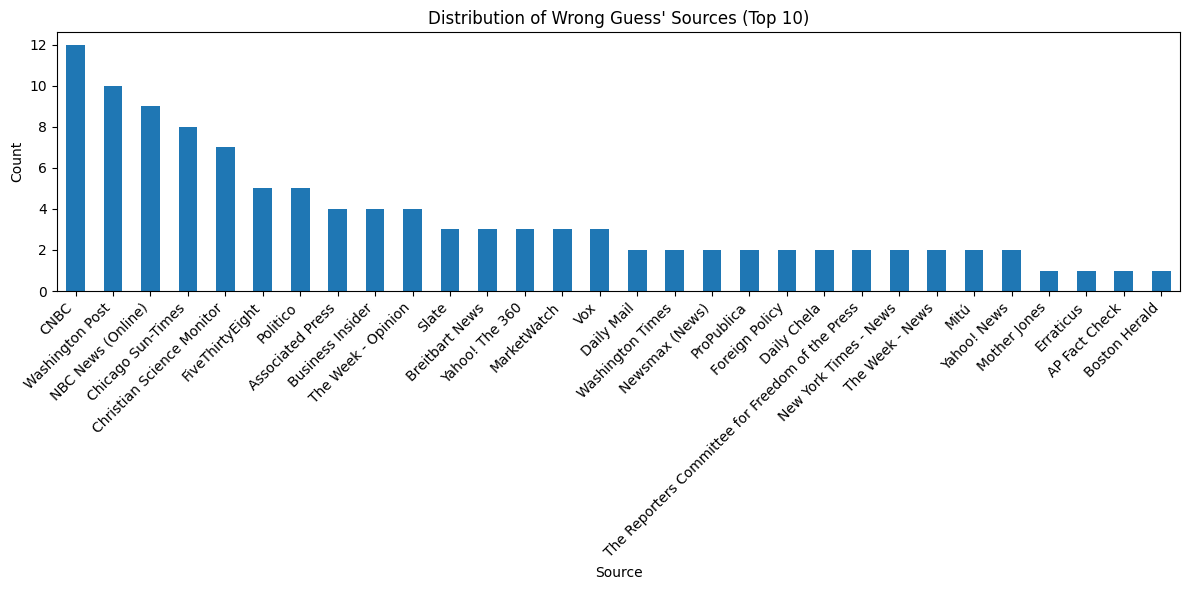

In [85]:
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Get the top 10 sources
top_sources = source_counts.head(30)

# Create a bar plot for the top 10 sources
plt.figure(figsize=(12, 6))
top_sources.plot(kind='bar')

# Customize the plot
plt.title("Distribution of Wrong Guess' Sources (Top 10)")
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

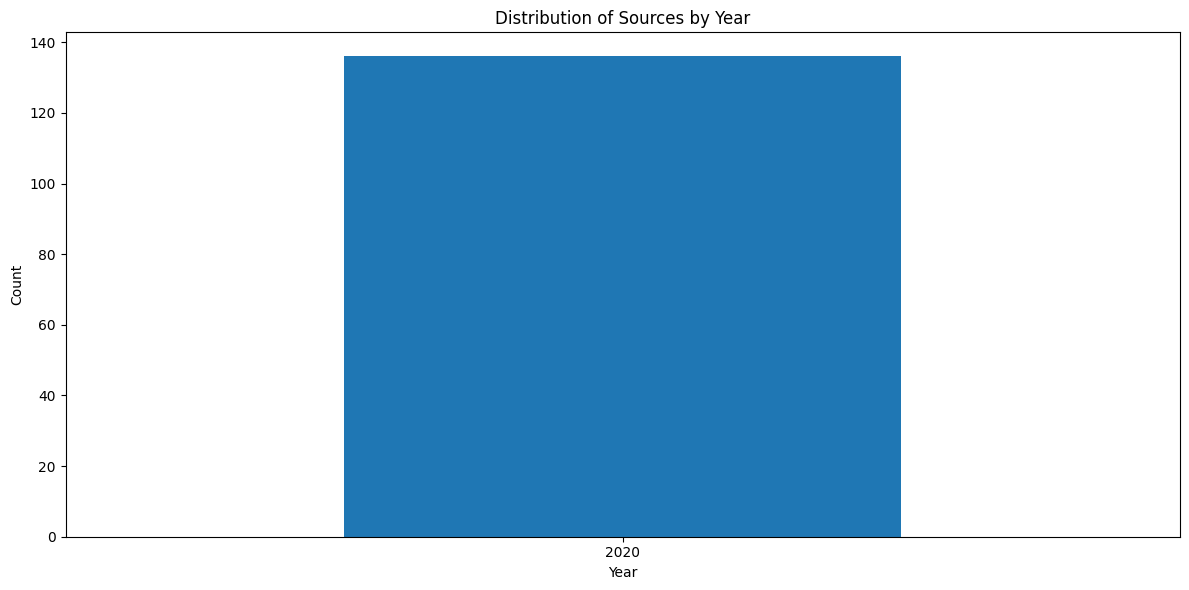

In [86]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [87]:
# for i in wrong_guesses[:50]:
#   decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

#   print("Input text:")
#   print(decoded_text)
#   print("True label:")
#   print(y_test.iloc[i])
#   print("Predicted label:")
#   print(predictions_model.numpy()[i])

#   print("-" * 50)


In [88]:
decoded_wrong_guesses_df = pd.DataFrame({'text': decoded_wrong_guesses_text})

# Now you can save it to a CSV file
decoded_wrong_guesses_df.to_csv('bert_cls_fine_tuning_wrong guess(7.24.24).csv', index=False)